In [1]:
#%%
# This is where I might put helper functions and scripts
import csv
from datetime import datetime
import numpy as np
import trompy as tp

def get_FEDevents(filename, eventname):
    
    formats = ['%Y-%m-%d %H:%M:%S', '%m/%d/%Y %H:%M:%S']

    file = open (filename)
    csvreader= csv.reader(file)
    next(csvreader)
    rows= []
    for row in csvreader:
        rows.append(row)

    # works out which format should be used


    
    try:
        tmp_date_time_obj = datetime.strptime(rows[0][0], formats[0])
        date_format = formats[0]
    except ValueError:
        tmp_date_time_obj = datetime.strptime(rows[0][0], formats[1])
        date_format = formats[1]

    timestamps = []
    for row in rows: 
        if row[9] == eventname:
            date_time_obj = datetime.strptime(row [0], date_format)
            timestamps.append (date_time_obj)
           
    t0 = rows[0] [0] 
    day = t0.split()[0] 
    lightson = day + " 07:00:00" 
    refpoint = datetime.strptime(lightson, date_format)
    
    pellettimes = []
    for t in timestamps:
        Deltat = t-refpoint
        Deltatinseconds = Deltat.total_seconds()
        Deltatinhours = Deltatinseconds/3600
        pellettimes.append(Deltatinhours)

    return pellettimes

def get_data_subset(dictionary, selectors, verbose=True):

    output_dictionary = dictionary.copy()
    for key, value in selectors.items():
        for mouse_id in dictionary.keys():
            try:
                if output_dictionary[mouse_id][key] != value:
                    output_dictionary.pop(mouse_id)
            except KeyError: pass

    if verbose:
        print("{} items in output dictionary".format(len(output_dictionary.keys())))
    
    return output_dictionary

def get_data_fields(dictionary, fields, selectors):

    output_list = []
    reduced_dictionary = get_data_subset(dictionary, selectors)
    
    if len(reduced_dictionary.keys()) > 0:

        for field in fields:
            output_sublist =[]
            try:
                for key in reduced_dictionary.keys():
                    output_sublist.append(reduced_dictionary[key][field])
            except KeyError:
                print("{} is not a key in selected dictionary".format(field))
                return
            output_list.append(output_sublist)
    else:
        print("No data in fields in selected dictionary")

    if len(output_list) == 1:
        output_list = output_list[0]
        
    return output_list

def get_intermealinterval (pellettimes):
    IPIs = np.diff(pellettimes)
    IMI= np.mean([x for x in IPIs if x > (1/60)])
    return IMI
#%%

# function to get timestamps from fed csv files
metafile = "/workspaces/FEDPROFERENCE/FEDXD_METAFILE.xls"
rows, header = tp.metafilereader(metafile, sheetname="METAFILE")

mice = {}
for row in rows:
    mouse_id = row[0]
    if mouse_id not in mice.keys():
        mice[mouse_id] = {}
        mice[mouse_id]["SEX"] = row[1]
        mice[mouse_id]["CHOICE_SESSION"] = row[4]
        mice[mouse_id]["FED_PELLET"] = row[5]
        mice[mouse_id]["MODE"] = row[6]
        mice[mouse_id]["DIET"] = row[7]

for key in mice.keys():
    for row in rows:
        if row[0] == key and row[6] == "FR":
            filename = "/workspaces/FEDPROFERENCE/data/{}".format(row[3])
            if row[5] == "CAS20":
                mice[key]["CAS20_timestamps"] = get_FEDevents(filename, "Pellet")
            elif row[7] == "PR":
                mice[key]["pr_timestamps"] = get_FEDevents(filename, "Pellet")
            elif row[7] == "NR":
                mice[key]["nr_timestamps"] = get_FEDevents(filename, "Pellet")
            else:
                print(row[27], "is not a valid type of pellet for", key)






# %%
# to get average pellets per day
for key in mice.keys():
    mice[key]["grain_avg_pellets"] = len(mice[key]["grain_timestamps"]) / 3
    mice[key]["pr_avg_pellets"] = len(mice[key]["pr_timestamps"]) / 7
    mice[key]["nr_avg_pellets"] = len(mice[key]["nr_timestamps"]) / 7

# %%
# 
def get_pellets_per_day(timestamps, start_time=4, days=7):
    pellets_per_day = []
    for day in range(days):
        pellets = [t for t in timestamps if (t>day*24) and (t<(day+1)*24)]
        n_pellets = len(pellets)
        pellets_per_day.append(n_pellets)

    return pellets_per_day

for key in mice.keys():
    mice[key]["grain_pellets_per_day"] = get_pellets_per_day(mice[key]["grain_timestamps"], days=3)
    mice[key]["pr_pellets_per_day"] = get_pellets_per_day(mice[key]["pr_timestamps"])
    mice[key]["nr_pellets_per_day"] = get_pellets_per_day(mice[key]["nr_timestamps"])

# %%
# assemble pellets per day for whole timecourse
for key in mice.keys():
    if mice[key]["order"] == 2:
        mice[key]["all_pellets_per_day"] = mice[key]["grain_pellets_per_day"] + \
            mice[key]["pr_pellets_per_day"] + mice[key]["nr_pellets_per_day"]
    else:
                mice[key]["all_pellets_per_day"] = mice[key]["grain_pellets_per_day"] + \
                    mice[key]["nr_pellets_per_day"] + mice[key]["pr_pellets_per_day"]



# %%
# add meal parameters to dictionary

def get_interpellet_intervals(pellettimes):
    IPIs = np.diff(pellettimes)
    return IPIs

def get_intermealinterval (pellettimes):
    IPIs = np.diff(pellettimes)
    IMI= np.mean([x for x in IPIs if x > (1/60)])
    return IMI

def get_mealsize(pellettimes):
    """
    calculates meal size from times of pellets
    parameters 
    ----------
    pellettimes : list of floats
        timestamps of pellet deliveries

    returns
    --------
    mealsize : float 
        mean size of meal in pellets 
    """
    npellets = len(pellettimes)
    IPIs = np.diff(pellettimes)
    nmeals = len([idx for idx, val in enumerate(IPIs) if val > 1/60])
    mealsize = npellets/nmeals

    return mealsize

for key in mice.keys():
    pr_timestamps = mice[key]["pr_timestamps"]
    mice[key]["interpellet_intervals_pr"] = get_interpellet_intervals(pr_timestamps)
    mice[key]["intermeal_interval_pr"] = get_intermealinterval(pr_timestamps)
    mice[key]["mealsize_pr"] = get_mealsize(pr_timestamps)

    nr_timestamps = mice[key]["nr_timestamps"]
    mice[key]["interpellet_intervals_nr"] = get_interpellet_intervals(nr_timestamps)
    mice[key]["intermeal_interval_nr"] = get_intermealinterval(nr_timestamps)
    mice[key]["mealsize_nr"] = get_mealsize(nr_timestamps)
    
# %%




FileNotFoundError: [Errno 2] No such file or directory: '\\workspaces\\FEDPROFERENCE\\FEDXD_METAFILE.xls'

In [2]:
def get_FEDevents(filename, eventname):
    formats = ['%m/%d/%Y %H:%M:%S']  # Adjusted to the format in your CSV
    file = open(filename)
    csvreader = csv.reader(file)
    next(csvreader)  # Skip header
    rows = [row for row in csvreader]

    if not rows:  # Check if rows is empty
        print(f"No data in file {filename}.")
        return []

    # Assuming the first column contains the date and time info
    # and the "Event" column is consistent with the provided files
    event_column_index = 9  # Based on your CSV structure
    
    # Determine which date format should be used (assuming consistency, so just using one format)
    date_format = formats[0]

    timestamps = []
    for row in rows:
        if row[event_column_index] == eventname:
            date_time_obj = datetime.strptime(row[0], date_format)
            timestamps.append(date_time_obj)

    if not timestamps:  # If no events match, return an empty list
        return []

    # Calculate time since "lights on", using the first event as reference if needed
    t0 = timestamps[0].strftime(date_format)
    day = t0.split()[0]
    lightson = day + " 07:00:00"  # Assuming lights on at 7 AM
    refpoint = datetime.strptime(lightson, date_format)

    pellettimes = [(t - refpoint).total_seconds() / 3600 for t in timestamps]

    return pellettimes


In [3]:
#%%
# This is where I might put helper functions and scripts
import csv
from datetime import datetime
import numpy as np
import trompy as tp

def get_FEDevents(filename, eventname):
    formats = ['%m/%d/%Y %H:%M:%S']  # Adjusted to the format in your CSV
    file = open(filename)
    csvreader = csv.reader(file)
    next(csvreader)  # Skip header
    rows = [row for row in csvreader]

    if not rows:  # Check if rows is empty
        print(f"No data in file {filename}.")
        return []

    # Assuming the first column contains the date and time info
    # and the "Event" column is consistent with the provided files
    event_column_index = 9  # Based on your CSV structure
    
    # Determine which date format should be used (assuming consistency, so just using one format)
    date_format = formats[0]

    timestamps = []
    for row in rows:
        if row[event_column_index] == eventname:
            date_time_obj = datetime.strptime(row[0], date_format)
            timestamps.append(date_time_obj)

    if not timestamps:  # If no events match, return an empty list
        return []

    # Calculate time since "lights on", using the first event as reference if needed
    t0 = timestamps[0].strftime(date_format)
    day = t0.split()[0]
    lightson = day + " 07:00:00"  # Assuming lights on at 7 AM
    refpoint = datetime.strptime(lightson, date_format)

    pellettimes = [(t - refpoint).total_seconds() / 3600 for t in timestamps]

    return pellettimes


def get_data_subset(dictionary, selectors, verbose=True):

    output_dictionary = dictionary.copy()
    for key, value in selectors.items():
        for mouse_id in dictionary.keys():
            try:
                if output_dictionary[mouse_id][key] != value:
                    output_dictionary.pop(mouse_id)
            except KeyError: pass

    if verbose:
        print("{} items in output dictionary".format(len(output_dictionary.keys())))
    
    return output_dictionary

def get_data_fields(dictionary, fields, selectors):

    output_list = []
    reduced_dictionary = get_data_subset(dictionary, selectors)
    
    if len(reduced_dictionary.keys()) > 0:

        for field in fields:
            output_sublist =[]
            try:
                for key in reduced_dictionary.keys():
                    output_sublist.append(reduced_dictionary[key][field])
            except KeyError:
                print("{} is not a key in selected dictionary".format(field))
                return
            output_list.append(output_sublist)
    else:
        print("No data in fields in selected dictionary")

    if len(output_list) == 1:
        output_list = output_list[0]
        
    return output_list

def get_intermealinterval (pellettimes):
    IPIs = np.diff(pellettimes)
    IMI= np.mean([x for x in IPIs if x > (1/60)])
    return IMI
#%%

# function to get timestamps from fed csv files
metafile = "/workspaces/FEDPROFERENCE/FEDXD_METAFILE.xls"
rows, header = tp.metafilereader(metafile, sheetname="METAFILE")

mice = {}
for row in rows:
    mouse_id = row[0]
    if mouse_id not in mice.keys():
        mice[mouse_id] = {}
        mice[mouse_id]["SEX"] = row[1]
        mice[mouse_id]["CHOICE_SESSION"] = row[4]
        mice[mouse_id]["FED_PELLET"] = row[5]
        mice[mouse_id]["MODE"] = row[6]
        mice[mouse_id]["DIET"] = row[7]

for key in mice.keys():
    for row in rows:
        if row[0] == key and row[6] == "FR":
            filename = "/workspaces/FEDPROFERENCE/data/{}".format(row[3])
            if row[5] == "CAS20":
                mice[key]["CAS20_timestamps"] = get_FEDevents(filename, "Pellet")
            elif row[7] == "PR":
                mice[key]["pr_timestamps"] = get_FEDevents(filename, "Pellet")
            elif row[7] == "NR":
                mice[key]["nr_timestamps"] = get_FEDevents(filename, "Pellet")
            else:
                print(row[27], "is not a valid type of pellet for", key)






# %%
# to get average pellets per day
for key in mice.keys():
    mice[key]["grain_avg_pellets"] = len(mice[key]["grain_timestamps"]) / 3
    mice[key]["pr_avg_pellets"] = len(mice[key]["pr_timestamps"]) / 7
    mice[key]["nr_avg_pellets"] = len(mice[key]["nr_timestamps"]) / 7

# %%
# 
def get_pellets_per_day(timestamps, start_time=4, days=7):
    pellets_per_day = []
    for day in range(days):
        pellets = [t for t in timestamps if (t>day*24) and (t<(day+1)*24)]
        n_pellets = len(pellets)
        pellets_per_day.append(n_pellets)

    return pellets_per_day

for key in mice.keys():
    mice[key]["grain_pellets_per_day"] = get_pellets_per_day(mice[key]["grain_timestamps"], days=3)
    mice[key]["pr_pellets_per_day"] = get_pellets_per_day(mice[key]["pr_timestamps"])
    mice[key]["nr_pellets_per_day"] = get_pellets_per_day(mice[key]["nr_timestamps"])

# %%
# assemble pellets per day for whole timecourse
for key in mice.keys():
    if mice[key]["order"] == 2:
        mice[key]["all_pellets_per_day"] = mice[key]["grain_pellets_per_day"] + \
            mice[key]["pr_pellets_per_day"] + mice[key]["nr_pellets_per_day"]
    else:
                mice[key]["all_pellets_per_day"] = mice[key]["grain_pellets_per_day"] + \
                    mice[key]["nr_pellets_per_day"] + mice[key]["pr_pellets_per_day"]



# %%
# add meal parameters to dictionary

def get_interpellet_intervals(pellettimes):
    IPIs = np.diff(pellettimes)
    return IPIs

def get_intermealinterval (pellettimes):
    IPIs = np.diff(pellettimes)
    IMI= np.mean([x for x in IPIs if x > (1/60)])
    return IMI

def get_mealsize(pellettimes):
    """
    calculates meal size from times of pellets
    parameters 
    ----------
    pellettimes : list of floats
        timestamps of pellet deliveries

    returns
    --------
    mealsize : float 
        mean size of meal in pellets 
    """
    npellets = len(pellettimes)
    IPIs = np.diff(pellettimes)
    nmeals = len([idx for idx, val in enumerate(IPIs) if val > 1/60])
    mealsize = npellets/nmeals

    return mealsize

for key in mice.keys():
    pr_timestamps = mice[key]["pr_timestamps"]
    mice[key]["interpellet_intervals_pr"] = get_interpellet_intervals(pr_timestamps)
    mice[key]["intermeal_interval_pr"] = get_intermealinterval(pr_timestamps)
    mice[key]["mealsize_pr"] = get_mealsize(pr_timestamps)

    nr_timestamps = mice[key]["nr_timestamps"]
    mice[key]["interpellet_intervals_nr"] = get_interpellet_intervals(nr_timestamps)
    mice[key]["intermeal_interval_nr"] = get_intermealinterval(nr_timestamps)
    mice[key]["mealsize_nr"] = get_mealsize(nr_timestamps)
    
# %%




FileNotFoundError: [Errno 2] No such file or directory: '\\workspaces\\FEDPROFERENCE\\FEDXD_METAFILE.xls'

In [4]:
# Ensure trompy is correctly installed and imported, or use an alternative method to read the Excel file.

# Read the metafile (assuming tp.metafilereader is correctly implemented)
metafile_path = "/workspaces/FEDPROFERENCE/FEDXD_METAFILE.xls"  # Adjusted path to the uploaded file
rows, header = tp.metafilereader(metafile_path, sheetname="METAFILE")

mice = {}
# Iterate through each row in the metafile to populate the mice dictionary
for row in rows:
    mouse_id, choice_session = row[0], row[4]  # Assuming these are the correct indices for MOUSEID and CHOICE_SESSION
    if mouse_id not in mice:
        mice[mouse_id] = {"CHOICE_SESSION": choice_session, "events": []}  # Initialize dictionary

# Now, focus on processing FED event data for CHOICE_SESSION
for mouse_id, data in mice.items():
    choice_session = data["CHOICE_SESSION"]
    # Filter rows for the current mouse and its CHOICE_SESSION
    session_rows = [row for row in rows if row[0] == mouse_id and row[4] == choice_session]
    
    for row in session_rows:
        # Assuming row[3] is the filename/path for the FED event data
        filename = f"/workspaces/FEDPROFERENCE/data/{row[3]}"  # Adjust path as needed
        eventname = "Pellet"  # Adjust as needed based on your CSV files
        # Collect FED event timestamps
        timestamps = get_FEDevents(filename, eventname)
        # Store timestamps in the mice dictionary
        if timestamps:  # Check if timestamps were found
            mice[mouse_id]["events"].extend(timestamps)

# This approach organizes the FED event timestamps by mouse and by CHOICE_SESSION.


FileNotFoundError: [Errno 2] No such file or directory: '\\workspaces\\FEDPROFERENCE\\FEDXD_METAFILE.xls'

In [5]:
# Assuming the metafile processing part remains the same

# Extending the mice dictionary to include pellet types
for mouse_id, data in mice.items():
    choice_session = data["CHOICE_SESSION"]
    session_rows = [row for row in rows if row[0] == mouse_id and row[4] == choice_session]

    # Initialize dictionary entries for pellet counts
    data["pellet_counts"] = {}  # This will store counts for each pellet type

    for row in session_rows:
        filename = f"/workspaces/FEDPROFERENCE/data/{row[3]}"  # Adjust path as needed
        # Assuming pellet types are differentiated somehow in your data or filenames
        # For illustration, let's say pellet types are indicated in `FED_PELLET` column (row[5])
        pellet_type = row[5]  # Identify the pellet type
        if pellet_type not in data["pellet_counts"]:
            data["pellet_counts"][pellet_type] = 0  # Initialize count for this pellet type
        
        # Here you might need to adjust the event name to match the specific pellet type
        # This is an example assuming all pellets are logged as "Pellet" events
        # You might need to adjust this logic based on how your data indicates pellet type
        timestamps = get_FEDevents(filename, "Pellet")  # Collect timestamps
        data["pellet_counts"][pellet_type] += len(timestamps)  # Count pellets for the type

# Now, `mice[mouse_id]["pellet_counts"]` contains the counts of each pellet type taken in the choice session


NameError: name 'mice' is not defined

In [6]:
# Initialize a dictionary to hold the lists for each group
grouped_data = {}

# Iterate through each mouse to organize their data into the corresponding list
for mouse_id, data in mice.items():
    # Using .get() to avoid KeyError, defaulting to 'Unknown' if not found
    sex = data.get("SEX", "Unknown")  # Consider how you want to handle unknown sexes
    choice_session = data.get("CHOICE_SESSION", "Unknown")
    diet = data.get("DIET", "Unknown")
    
    # Check if 'pellet_counts' exists to avoid further errors
    pellet_counts = data.get("pellet_counts", {})
    
    # Iterate through pellet counts to further classify by pellet type
    for pellet_type, count in pellet_counts.items():
        # Define a unique key for the group
        key = f"{sex}_{choice_session}_{diet}_{pellet_type}"
        
        # Initialize the list for this group if it doesn't exist
        if key not in grouped_data:
            grouped_data[key] = []
        
        # Append the mouse data to the list for its group
        grouped_data[key].append({
            "MOUSEID": mouse_id,
            "COUNT": count
        })


NameError: name 'mice' is not defined

In [7]:
# Initialize a structure to store data across all choice sessions
all_sessions_data = {}

# Iterate through each row directly, allowing for multiple sessions per mouse
for row in rows:
    mouse_id = row[0]
    choice_session = row[4]  # This is now directly taken from each row
    pellet_type = row[5]
    filename = f"/workspaces/FEDPROFERENCE/data/{row[3]}"
    
    # Unique key for each mouse, session, and pellet type
    key = f"{mouse_id}_{choice_session}_{pellet_type}"
    
    # Initialize the entry if it doesn't exist
    if key not in all_sessions_data:
        all_sessions_data[key] = {
            "MOUSEID": mouse_id,
            "CHOICE_SESSION": choice_session,
            "PELLET_TYPE": pellet_type,
            "COUNT": 0
        }
    
    # Collect timestamps and count pellets for the type
    timestamps = get_FEDevents(filename, "Pellet")
    all_sessions_data[key]["COUNT"] += len(timestamps)

# Convert all_sessions_data dictionary to a list of dictionaries for each mouse/session/pellet type
all_sessions_list = list(all_sessions_data.values())


NameError: name 'rows' is not defined

In [8]:
# Initialize a dictionary to hold lists for each unique group
grouped_lists = {}

# Iterate through the rows to process and group data
for row in rows:
    mouse_id = row[0]
    sex = row[1]  # Assuming this is the correct column for SEX
    diet = row[7]  # Assuming this is the correct column for DIET
    choice_session = row[4]
    pellet_type = row[5]
    filename = f"/workspaces/FEDPROFERENCE/data/{row[3]}"
    
    # Create a unique key for each group
    group_key = f"{sex}_{diet}_{choice_session}_{pellet_type}"
    
    # Collect timestamps for this row's file and pellet event
    timestamps = get_FEDevents(filename, "Pellet")
    pellet_count = len(timestamps)
    
    # Initialize the list for this group if it doesn't exist
    if group_key not in grouped_lists:
        grouped_lists[group_key] = []
    
    # Append the data for this mouse to the list for its group
    grouped_lists[group_key].append({
        "MOUSEID": mouse_id,
        "SEX": sex,
        "DIET": diet,
        "CHOICE_SESSION": choice_session,
        "PELLET_TYPE": pellet_type,
        "COUNT": pellet_count
    })

# At this point, 'grouped_lists' contains separate lists for each combination of SEX, DIET, CHOICE_SESSION, and PELLET_TYPE


NameError: name 'rows' is not defined

In [9]:
import pandas as pd

# Assuming 'grouped_lists' is your dictionary containing the grouped data

# Flatten the grouped data into a single list of dictionaries
flattened_data = []
for group_data in grouped_lists.values():
    flattened_data.extend(group_data)

# Convert the flattened data list into a DataFrame
df = pd.DataFrame(flattened_data)

# Display the first few rows of the DataFrame to verify
df


""


In [10]:
import numpy as np

# Assuming you're within the loop where you collect FED event timestamps for each session

# For each mouse session, after collecting timestamps
timestamps = get_FEDevents(filename, "Pellet")  # This gets the timestamps for the session

# Convert timestamps to hours since the first event (if not already in this format)
# Assumes timestamps are sorted in ascending order
pellettimes = [((t - timestamps[0]).total_seconds() / 3600) for t in timestamps]

# Calculate Interpellet Intervals (IPIs), Intermeal Interval (IMI), and Meal Size
IPIs = get_interpellet_intervals(pellettimes)
IMI = get_intermealinterval(pellettimes)
mealsize = get_mealsize(pellettimes)

# Now, you can include IMI and Meal Size in your data structure for this session
grouped_lists[group_key].append({
    "MOUSEID": mouse_id,
    "SEX": sex,
    "DIET": diet,
    "CHOICE_SESSION": choice_session,
    "PELLET_TYPE": pellet_type,
    "COUNT": pellet_count,
    "IMI": IMI,
    "MEALSIZE": mealsize
})


NameError: name 'filename' is not defined

In [3]:
import pandas as pd
import os

# Define the path to the directory
directory_path = '../data/'

# Iterate through the files in the directory
for filename in os.listdir(directory_path):
    # Check if the filename starts with 'FED005'
    if filename.startswith('FED005') and filename.endswith('.CSV'):
        file_path = os.path.join(directory_path, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Insert two empty columns right after the first column
        df.insert(1, 'New Column 1', '')
        df.insert(2, 'New Column 2', '')
        
        # Save the modified DataFrame back to the CSV file
        df.to_csv(file_path, index=False)

        print(f'Processed file: {filename}')


Processed file: FED005_032923_02.CSV
Processed file: FED005_033023_01.CSV
Processed file: FED005_040123_02.CSV
Processed file: FED005_040223_00.CSV
Processed file: FED005_040323_01.CSV
Processed file: FED005_040923_00.CSV
Processed file: FED005_041023_00.CSV
Processed file: FED005_041123_00.CSV
Processed file: FED005_041223_00.CSV
Processed file: FED005_041323_00.CSV
Processed file: FED005_041423_00.CSV
Processed file: FED005_041523_00.CSV
Processed file: FED005_041623_00.CSV
Processed file: FED005_041723_00.CSV
Processed file: FED005_041823_00.CSV
Processed file: FED005_041923_00.CSV
Processed file: FED005_042023_00.CSV
Processed file: FED005_042123_03.CSV
Processed file: FED005_042223_00.CSV
Processed file: FED005_042323_00.CSV
Processed file: FED005_042423_00.CSV
Processed file: FED005_042523_00.CSV


# <font color = "gold"> Writing the script from scratch </font>

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import trompy as tp
import csv
from datetime import datetime


# the next two lines will expand the printed tables
pd.options.display.max_rows= 40000
pd.options.display.max_columns= 40000


ctl_color= "gray"
exp_color="deepskyblue"
fig_folder=r"../plots\\"
READ_METAFILE= pd.read_excel(r"..\FEDXD_METAFILE.xls" ,sheet_name="METAFILE" )

READ_METAFILE


,MOUSEID,SEX,BATCH,FEDFILE,CHOICE_SESSION,FED_PELLET,MODE,DIET
0,FEDXDF1,F,1,FED001_032923_02.CSV,0,MIX,FF,PR
1,FEDXDF1,F,1,FED001_033023_01.CSV,0,MIX,FR,PR
2,FEDXDF1,F,1,FED001_040923_00.CSV,1,CAS20,FR,PR
3,FEDXDF1,F,1,FED002_040923_00.CSV,1,CAS5,FR,PR
4,FEDXDF1,F,1,FED001_041323_00.CSV,2,CAS20,FR,PR
5,FEDXDF1,F,1,FED002_041323_00.CSV,2,SUC,FR,PR
6,FEDXDF1,F,1,FED001_041723_00.CSV,3,CAS5,FR,PR
7,FEDXDF1,F,1,FED002_041723_00.CSV,3,SUC,FR,PR
8,FEDXDF1,F,1,FED001_042123_03.CSV,4,CAS5,CE,PR
9,FEDXDF1,F,1,FED002_042123_02.CSV,4,SUC,CE,PR


In [13]:
metafile_path = "../FEDXD_METAFILE.xls"  # Adjusted path to the uploaded file
rows, header = tp.metafilereader(metafile_path, sheetname="METAFILE")

def get_FEDevents(filename, eventname):
    formats = ['%m/%d/%Y %H:%M:%S']  # Adjusted to the format in your CSV
    file = open(filename)
    csvreader = csv.reader(file)
    next(csvreader)  # Skip header
    rows = [row for row in csvreader]

    if not rows:  # Check if rows is empty
        print(f"No data in file {filename}.")
        return []

    # Assuming the first column contains the date and time info
    # and the "Event" column is consistent with the provided files
    event_column_index = 9  # Based on your CSV structure
    
    # Determine which date format should be used (assuming consistency, so just using one format)
    date_format = formats[0]

    timestamps = []
    for row in rows:
        if row[event_column_index] == eventname:
            date_time_obj = datetime.strptime(row[0], date_format)
            timestamps.append(date_time_obj)

    if not timestamps:  # If no events match, return an empty list
        return []

    # Calculate time since "lights on", using the first event as reference if needed
    t0 = timestamps[0].strftime(date_format)
    day = t0.split()[0]
    lightson = day + " 07:00:00"  # Assuming lights on at 7 AM
    refpoint = datetime.strptime(lightson, date_format)

    pellettimes = [(t - refpoint).total_seconds() / 3600 for t in timestamps]

    return pellettimes
# Initialize a dictionary to hold lists for each unique group
grouped_lists = {}

# Iterate through the rows to process and group data
for row in rows:
    mouse_id = row[0]
    sex = row[1]  # Assuming this is the correct column for SEX
    diet = row[7]  # Assuming this is the correct column for DIET
    choice_session = row[4]
    pellet_type = row[5]
    filename = f"../data/{row[3]}"


    # Create a unique key for each group
    group_key = f"{sex}_{diet}_{choice_session}_{pellet_type}"
    
    # Collect timestamps for this row's file and pellet event
    timestamps = get_FEDevents(filename, "Pellet")
    pellet_count = len(timestamps)
    
    # Initialize the list for this group if it doesn't exist
    if group_key not in grouped_lists:
        grouped_lists[group_key] = []
    
    # Append the data for this mouse to the list for its group
    grouped_lists[group_key].append({
        "MOUSEID": mouse_id,
        "SEX": sex,
        "DIET": diet,
        "CHOICE_SESSION": choice_session,
        "PELLET_TYPE": pellet_type,
        "COUNT": pellet_count
    })

In [14]:
# Flatten the grouped data into a single list of dictionaries
flattened_data = []
for group_data in grouped_lists.values():
    flattened_data.extend(group_data)

# Convert the flattened data list into a DataFrame
df = pd.DataFrame(flattened_data)

# Display the first few rows of the DataFrame to verify
df


,MOUSEID,SEX,DIET,CHOICE_SESSION,PELLET_TYPE,COUNT
0,FEDXDF1,F,PR,0.0,MIX,210
1,FEDXDF1,F,PR,0.0,MIX,296
2,FEDXDF2,F,PR,0.0,MIX,350
3,FEDXDF2,F,PR,0.0,MIX,330
4,FEDXDF3,F,PR,0.0,MIX,291
5,FEDXDF3,F,PR,0.0,MIX,375
6,FEDXDF4,F,PR,0.0,MIX,294
7,FEDXDF4,F,PR,0.0,MIX,312
8,FEDXDF5,F,PR,0.0,MIX,227
9,FEDXDF5,F,PR,0.0,MIX,363


In [35]:
from datetime import datetime, timedelta
import csv

def get_FEDevents_hourly(filename, eventname):
    formats = ['%m/%d/%Y %H:%M:%S']  # Adjusted to the format in your CSV
    file = open(filename)
    csvreader = csv.reader(file)
    next(csvreader)  # Skip header
    rows = [row for row in csvreader]

    if not rows:
        print(f"No data in file {filename}.")
        return []

    event_column_index = 9
    date_format = formats[0]

    timestamps = [datetime.strptime(row[0], date_format) for row in rows if row[event_column_index] == eventname]
    
    if not timestamps:
        return []

    # Sort timestamps to ensure chronological order
    timestamps.sort()

    # Calculate hourly counts, ignoring the first and last hour
    first_event_time = timestamps[0]
    last_event_time = timestamps[-1]
    current_time = first_event_time + timedelta(hours=1)  # Start from the second hour
    end_time = last_event_time  # Include events up to the last hour

    hourly_counts = []
    while current_time < end_time:
        next_hour = current_time + timedelta(hours=1)
        count = sum(1 for t in timestamps if current_time <= t < next_hour)
        hourly_counts.append(count)
        current_time = next_hour

    # Remove the count for the last hour, as we need to ignore it
    if hourly_counts:
        hourly_counts = hourly_counts[:-1]

    return hourly_counts

# Initialize a dictionary to hold lists for each unique group
grouped_lists = {}

# Assuming you've already read the metadata into `rows`
for row in rows:
    mouse_id = row[0]
    sex = row[1]
    diet = row[7]
    choice_session = row[4]
    pellet_type = row[5]
    filename = f"../data/{row[3]}"

    group_key = f"{sex}_{diet}_{choice_session}_{pellet_type}"
    
    # Collect hourly pellet counts for this row's file and pellet event
    hourly_counts = get_FEDevents_hourly(filename, "Pellet")
    
    # Initialize the list for this group if it doesn't exist
    if group_key not in grouped_lists:
        grouped_lists[group_key] = []
    
    # Append the data for this mouse to the list for its group
    grouped_lists[group_key].append({
        "MOUSEID": mouse_id,
        "SEX": sex,
        "DIET": diet,
        "CHOICE_SESSION": choice_session,
        "PELLET_TYPE": pellet_type,
        "HOURLY_COUNTS": hourly_counts
    })


In [16]:
grouped_lists

{'F_PR_0.0_MIX': [{'MOUSEID': 'FEDXDF1',
   'SEX': 'F',
   'DIET': 'PR',
   'CHOICE_SESSION': 0.0,
   'PELLET_TYPE': 'MIX',
   'HOURLY_COUNTS': [7,
    0,
    22,
    0,
    0,
    9,
    10,
    10,
    9,
    8,
    10,
    17,
    9,
    12,
    7,
    9,
    5,
    11,
    4,
    10]},
  {'MOUSEID': 'FEDXDF1',
   'SEX': 'F',
   'DIET': 'PR',
   'CHOICE_SESSION': 0.0,
   'PELLET_TYPE': 'MIX',
   'HOURLY_COUNTS': [0,
    0,
    2,
    2,
    0,
    0,
    3,
    0,
    10,
    4,
    9,
    5,
    14,
    10,
    13,
    9,
    6,
    0,
    1,
    12,
    11,
    6,
    4,
    12,
    0,
    0,
    11,
    3,
    0,
    10,
    0,
    5,
    6,
    6,
    15,
    9,
    13,
    13,
    17,
    9,
    4,
    0,
    3,
    9,
    0,
    15]},
  {'MOUSEID': 'FEDXDF2',
   'SEX': 'F',
   'DIET': 'PR',
   'CHOICE_SESSION': 0.0,
   'PELLET_TYPE': 'MIX',
   'HOURLY_COUNTS': [30,
    3,
    0,
    3,
    2,
    4,
    5,
    6,
    10,
    23,
    14,
    22,
    26,
    22,
    17,
    27,


In [75]:


# Flatten the grouped_lists into a list of dictionaries
data_to_convert = []
for group_key, records in grouped_lists.items():
    for record in records:
        # Decompose the group_key back into its components if needed
        sex, diet, choice_session, pellet_type = group_key.split("_")
        # Create a new dictionary for each record that includes the group information
        record_data = {
            "MOUSEID": record["MOUSEID"],
            "SEX": record["SEX"],
            "DIET": record["DIET"],
            "CHOICE_SESSION": record["CHOICE_SESSION"],
            "PELLET_TYPE": record["PELLET_TYPE"],
            "HOURLY_COUNTS": record["HOURLY_COUNTS"]
        }
        # Append the new dictionary to the list
        data_to_convert.append(record_data)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data_to_convert)


# If you want each hourly count as a separate column, you can do the following:
# This assumes that the length of HOURLY_COUNTS is consistent across all records
if not df.empty and "HOURLY_COUNTS" in df.columns and df["HOURLY_COUNTS"].apply(len).max() > 0:
    max_length = df["HOURLY_COUNTS"].apply(len).max()
    hourly_counts_df = pd.DataFrame(df["HOURLY_COUNTS"].tolist(), index=df.index,
                                    columns=[f"Hour_{i+1}" for i in range(max_length)])
    df = pd.concat([df.drop(columns=["HOURLY_COUNTS"]), hourly_counts_df], axis=1)

# Show the DataFrame structure (optional)
print(df.head())

KeyError: 'HOURLY_COUNTS'

In [39]:
df
#df.to_csv('../results/HOUR_PELLET.csv', index=False)


,MOUSEID,SEX,DIET,CHOICE_SESSION,PELLET_TYPE,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Hour_24,Hour_25,Hour_26,Hour_27,Hour_28,Hour_29,Hour_30,Hour_31,Hour_32,Hour_33,Hour_34,Hour_35,Hour_36,Hour_37,Hour_38,Hour_39,Hour_40,Hour_41,Hour_42,Hour_43,Hour_44,Hour_45,Hour_46,Hour_47
0,FEDXDF1,F,PR,0.0,MIX,7.0,0.0,22.0,0.0,0.0,9.0,10.0,10.0,9.0,8.0,10.0,17.0,9.0,12.0,7.0,9.0,5.0,11.0,4.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FEDXDF1,F,PR,0.0,MIX,0.0,0.0,2.0,2.0,0.0,0.0,3.0,0.0,10.0,4.0,9.0,5.0,14.0,10.0,13.0,9.0,6.0,0.0,1.0,12.0,11.0,6.0,4.0,12.0,0.0,0.0,11.0,3.0,0.0,10.0,0.0,5.0,6.0,6.0,15.0,9.0,13.0,13.0,17.0,9.0,4.0,0.0,3.0,9.0,0.0,15.0,NaN
2,FEDXDF2,F,PR,0.0,MIX,30.0,3.0,0.0,3.0,2.0,4.0,5.0,6.0,10.0,23.0,14.0,22.0,26.0,22.0,17.0,27.0,23.0,25.0,13.0,15.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FEDXDF2,F,PR,0.0,MIX,2.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,5.0,15.0,11.0,14.0,17.0,17.0,14.0,12.0,0.0,0.0,9.0,9.0,13.0,1.0,14.0,12.0,0.0,0.0,3.0,4.0,0.0,0.0,3.0,7.0,11.0,11.0,14.0,12.0,15.0,13.0,17.0,6.0,13.0,9.0,5.0,8.0,3.0,2.0
4,FEDXDF3,F,PR,0.0,MIX,23.0,9.0,1.0,21.0,2.0,4.0,17.0,0.0,10.0,16.0,15.0,22.0,15.0,24.0,18.0,19.0,20.0,9.0,8.0,0.0,2.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,FEDXDF3,F,PR,0.0,MIX,7.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,4.0,9.0,17.0,7.0,18.0,17.0,22.0,11.0,7.0,3.0,0.0,1.0,19.0,14.0,0.0,17.0,0.0,2.0,2.0,3.0,12.0,1.0,0.0,8.0,0.0,17.0,12.0,13.0,28.0,6.0,16.0,10.0,14.0,6.0,13.0,6.0,6.0,12.0,0.0
6,FEDXDF4,F,PR,0.0,MIX,23.0,0.0,3.0,10.0,0.0,20.0,3.0,14.0,6.0,13.0,11.0,13.0,13.0,24.0,28.0,21.0,13.0,7.0,0.0,5.0,16.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,FEDXDF4,F,PR,0.0,MIX,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,14.0,12.0,12.0,13.0,17.0,18.0,14.0,14.0,7.0,0.0,1.0,15.0,15.0,0.0,13.0,2.0,0.0,0.0,5.0,0.0,4.0,0.0,10.0,6.0,7.0,8.0,6.0,7.0,11.0,13.0,11.0,5.0,17.0,6.0,0.0,12.0,5.0,0.0
8,FEDXDF5,F,PR,0.0,MIX,0.0,13.0,9.0,13.0,12.0,20.0,20.0,8.0,17.0,10.0,12.0,18.0,16.0,18.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,FEDXDF5,F,PR,0.0,MIX,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,7.0,8.0,14.0,18.0,13.0,18.0,19.0,20.0,13.0,12.0,17.0,1.0,0.0,10.0,0.0,22.0,0.0,0.0,1.0,1.0,1.0,4.0,0.0,12.0,0.0,14.0,11.0,14.0,13.0,15.0,16.0,4.0,20.0,11.0,9.0,0.0,16.0,NaN,NaN


In [22]:

import numpy as np
import pandas as pd
import csv
from datetime import datetime

def get_FEDevents(filename, eventname, formats=['%m/%d/%Y %H:%M:%S']):
    file = open(filename)
    csvreader = csv.reader(file)
    next(csvreader)  # Skip header
    rows = [row for row in csvreader]

    event_column_index = 9  # Adjust based on your CSV structure
    
    timestamps = [datetime.strptime(row[0], formats[0]) for row in rows if row[event_column_index] == eventname]
    
    if not timestamps:  # If no events match, return an empty list
        return []

    # Assuming lights on at 7 AM, calculate time since lights on in hours
    refpoint = timestamps[0].replace(hour=7, minute=0, second=0, microsecond=0)
    pellettimes = [(t - refpoint).total_seconds() / 3600 for t in timestamps]

    return pellettimes

def get_interpellet_intervals(pellettimes):
    IPIs = np.diff(pellettimes)
    return IPIs

def get_intermeal_interval(pellettimes):
    IPIs = np.diff(pellettimes)
    IMI = np.mean([x for x in IPIs if x > (1/60)])
    return IMI

def get_mealsize(pellettimes):
    npellets = len(pellettimes)
    IPIs = np.diff(pellettimes)
    nmeals = len([x for x in IPIs if x > 1/60]) + 1  # Adding 1 to account for the last meal
    mealsize = npellets / nmeals if nmeals else 0
    return mealsize

# Assuming 'rows' is populated from the metafile as in your original "read_data" script
grouped_lists = {}

for row in rows:
    mouse_id = row[0]
    sex = row[1]
    diet = row[7]
    choice_session = row[4]
    pellet_type = row[5]
    filename = f"../data/{row[3]}"

    group_key = f"{sex}_{diet}_{choice_session}_{pellet_type}"
    
    pellettimes = get_FEDevents(filename, "Pellet")
    pellet_count = len(pellettimes)
    IPIs = get_interpellet_intervals(pellettimes)
    IMI = get_intermeal_interval(pellettimes)
    mealsize = get_mealsize(pellettimes)
    
    if group_key not in grouped_lists:
        grouped_lists[group_key] = []
    
    grouped_lists[group_key].append({
        "MOUSEID": mouse_id,
        "SEX": sex,
        "DIET": diet,
        "CHOICE_SESSION": choice_session,
        "PELLET_TYPE": pellet_type,
        "COUNT": pellet_count,
        "AVERAGE_IPI": np.mean(IPIs) if IPIs.size > 0 else 0,
        "IMI": IMI,
        "MEAL_SIZE": mealsize
    })

# Convert grouped_lists to DataFrame
data_to_convert = [item for sublist in grouped_lists.values() for item in sublist]
df = pd.DataFrame(data_to_convert)

print(df.head())  # Display the first few rows of the DataFrame to verify the structure


C:\Users\hta031\AppData\Local\miniconda3\envs\DATA\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\hta031\AppData\Local\miniconda3\envs\DATA\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


   MOUSEID SEX DIET  CHOICE_SESSION PELLET_TYPE  COUNT  AVERAGE_IPI       IMI  \
0  FEDXDF1   F   PR             0.0         MIX    210     0.103978  0.386727   
1  FEDXDF1   F   PR             0.0         MIX    296     0.161298  0.343444   
2  FEDXDF2   F   PR             0.0         MIX    350     0.063399  0.169149   
3  FEDXDF2   F   PR             0.0         MIX    330     0.147774  0.299038   
4  FEDXDF3   F   PR             0.0         MIX    291     0.081382  0.214785   

   MEAL_SIZE  
0   3.750000  
1   2.160584  
2   2.734375  
3   2.049689  
4   2.694444  


In [23]:
df

,MOUSEID,SEX,DIET,CHOICE_SESSION,PELLET_TYPE,COUNT,AVERAGE_IPI,IMI,MEAL_SIZE
0,FEDXDF1,F,PR,0.0,MIX,210,0.103978,0.386727,3.750000
1,FEDXDF1,F,PR,0.0,MIX,296,0.161298,0.343444,2.160584
2,FEDXDF2,F,PR,0.0,MIX,350,0.063399,0.169149,2.734375
3,FEDXDF2,F,PR,0.0,MIX,330,0.147774,0.299038,2.049689
4,FEDXDF3,F,PR,0.0,MIX,291,0.081382,0.214785,2.694444
5,FEDXDF3,F,PR,0.0,MIX,375,0.129782,0.350043,2.757353
6,FEDXDF4,F,PR,0.0,MIX,294,0.081038,0.296296,3.721519
7,FEDXDF4,F,PR,0.0,MIX,312,0.156479,0.522766,3.391304
8,FEDXDF5,F,PR,0.0,MIX,227,0.072729,0.323197,4.540000
9,FEDXDF5,F,PR,0.0,MIX,363,0.127720,0.392505,3.129310


In [28]:
import numpy as np
import pandas as pd
import csv
from datetime import datetime

def get_FEDevents(filename, eventname, formats=['%m/%d/%Y %H:%M:%S']):
    file = open(filename)
    csvreader = csv.reader(file)
    next(csvreader)  # Skip header
    rows = [row for row in csvreader if row[9] == eventname]

    timestamps = [datetime.strptime(row[0], formats[0]) for row in rows]
    
    if not timestamps:
        return []

    refpoint = timestamps[0].replace(hour=7, minute=0, second=0, microsecond=0)
    pellettimes = [(t - refpoint).total_seconds() / 3600 for t in timestamps]

    return pellettimes

def get_meal_metrics(pellettimes, meal_threshold=1/60):
    """
    Calculates meal metrics including number of meals and average meal frequency.
    
    Parameters:
    pellettimes (list of float): timestamps of pellet deliveries in hours.
    meal_threshold (float): threshold in hours to define a new meal.
    
    Returns:
    tuple: containing mealsize, number of meals, and meal frequency.
    """
    npellets = len(pellettimes)
    if npellets <= 1:  # Cannot calculate meals or IPIs with 0 or 1 pellet
        return (0, 0, 0)
    
    IPIs = np.diff(pellettimes)
    nmeals = len([x for x in IPIs if x > meal_threshold]) + 1  # Count transitions to new meals
    mealsize = npellets / nmeals if nmeals else 0
    total_observation_period = max(pellettimes) - min(pellettimes)  # in hours
    meal_frequency = nmeals / total_observation_period if total_observation_period > 0 else 0

    return mealsize, nmeals, meal_frequency

# Assuming 'rows' is populated from the metafile as in your initial "read_data" script
grouped_lists = {}

for row in rows:
    mouse_id = row[0]
    sex = row[1]
    diet = row[7]
    choice_session = row[4]
    pellet_type = row[5]
    filename = f"../data/{row[3]}"

    group_key = f"{sex}_{diet}_{choice_session}_{pellet_type}"
    
    pellettimes = get_FEDevents(filename, "Pellet")
    pellet_count = len(pellettimes)
    mealsize, nmeals, meal_frequency = get_meal_metrics(pellettimes)
    
    if group_key not in grouped_lists:
        grouped_lists[group_key] = []
    
    grouped_lists[group_key].append({
        "MOUSEID": mouse_id,
        "SEX": sex,
        "DIET": diet,
        "CHOICE_SESSION": choice_session,
        "PELLET_TYPE": pellet_type,
        "COUNT": pellet_count,
        "MEAL_SIZE": mealsize,
        "NUMBER_OF_MEALS": nmeals,
        "MEAL_FREQUENCY": meal_frequency
    })

# Convert grouped_lists to DataFrame
data_to_convert = [item for sublist in grouped_lists.values() for item in sublist]
df = pd.DataFrame(data_to_convert)

print(df.head())  # Display the first few rows of the DataFrame to verify the structure





   MOUSEID SEX DIET  CHOICE_SESSION PELLET_TYPE  COUNT  MEAL_SIZE  \
0  FEDXDF1   F   PR             0.0         MIX    210   3.750000   
1  FEDXDF1   F   PR             0.0         MIX    296   2.160584   
2  FEDXDF2   F   PR             0.0         MIX    350   2.734375   
3  FEDXDF2   F   PR             0.0         MIX    330   2.049689   
4  FEDXDF3   F   PR             0.0         MIX    291   2.694444   

   NUMBER_OF_MEALS  MEAL_FREQUENCY  
0               56        2.576918  
1              137        2.879176  
2              128        5.785020  
3              161        3.311546  
4              108        4.576110  


In [29]:
df

,MOUSEID,SEX,DIET,CHOICE_SESSION,PELLET_TYPE,COUNT,MEAL_SIZE,NUMBER_OF_MEALS,MEAL_FREQUENCY
0,FEDXDF1,F,PR,0.0,MIX,210,3.750000,56,2.576918
1,FEDXDF1,F,PR,0.0,MIX,296,2.160584,137,2.879176
2,FEDXDF2,F,PR,0.0,MIX,350,2.734375,128,5.785020
3,FEDXDF2,F,PR,0.0,MIX,330,2.049689,161,3.311546
4,FEDXDF3,F,PR,0.0,MIX,291,2.694444,108,4.576110
5,FEDXDF3,F,PR,0.0,MIX,375,2.757353,136,2.801893
6,FEDXDF4,F,PR,0.0,MIX,294,3.721519,79,3.327133
7,FEDXDF4,F,PR,0.0,MIX,312,3.391304,92,1.890476
8,FEDXDF5,F,PR,0.0,MIX,227,4.540000,50,3.041979
9,FEDXDF5,F,PR,0.0,MIX,363,3.129310,116,2.508937


In [30]:
import numpy as np
import pandas as pd
import csv
from datetime import datetime, timedelta

def get_FEDevents(filename, eventname, formats=['%m/%d/%Y %H:%M:%S']):
    with open(filename) as file:
        csvreader = csv.reader(file)
        next(csvreader)  # Skip header
        rows = [row for row in csvreader if row[9] == eventname]

    timestamps = [datetime.strptime(row[0], formats[0]) for row in rows]
    
    if not timestamps:
        return []

    refpoint = timestamps[0].replace(hour=7, minute=0, second=0, microsecond=0)
    pellettimes = [(t - refpoint).total_seconds() / 3600 for t in timestamps]

    return pellettimes

def get_meal_and_snack_metrics(pellettimes, meal_threshold=1/60, min_pellets_for_meal=5):
    """
    Calculates meal and snack metrics, including number of meals, number of snacks, average meal frequency, and meal size.
    
    Parameters:
    pellettimes (list of float): Timestamps of pellet deliveries in hours.
    meal_threshold (float): Threshold in hours to define a new meal.
    min_pellets_for_meal (int): Minimum number of pellets for an eating event to be considered a meal.
    
    Returns:
    tuple: Containing meal size, number of meals, meal frequency, and number of snacks.
    """
    if len(pellettimes) < min_pellets_for_meal:
        # If total pellets are less than the minimum for a meal, consider all as snacks
        return (0, 0, 0, len(pellettimes))

    IPIs = np.diff(pellettimes)
    meal_indices = [i for i, ipi in enumerate(IPIs) if ipi > meal_threshold]
    
    # Adding the first and last indices to account for the start and end of the data
    meal_indices = [0] + meal_indices + [len(pellettimes) - 1]
    
    meals = [pellettimes[start:end+1] for start, end in zip(meal_indices[:-1], meal_indices[1:])]
    meal_counts = [len(meal) for meal in meals]
    
    nmeals = sum(1 for count in meal_counts if count >= min_pellets_for_meal)
    nsnacks = sum(1 for count in meal_counts if count < min_pellets_for_meal)
    
    npellets = len(pellettimes)
    mealsize = npellets / nmeals if nmeals else 0
    total_observation_period = max(pellettimes) - min(pellettimes)  # in hours
    meal_frequency = nmeals / total_observation_period if total_observation_period > 0 else 0

    return mealsize, nmeals, meal_frequency, nsnacks

# Assuming 'rows' is populated from the metafile as in your initial "read_data" script
grouped_lists = {}

for row in rows:
    mouse_id = row[0]
    sex = row[1]
    diet = row[7]
    choice_session = row[4]
    pellet_type = row[5]
    filename = f"../data/{row[3]}"

    group_key = f"{sex}_{diet}_{choice_session}_{pellet_type}"
    
    pellettimes = get_FEDevents(filename, "Pellet")
    pellet_count = len(pellettimes)
    mealsize, nmeals, meal_frequency, nsnacks = get_meal_and_snack_metrics(pellettimes)
    
    if group_key not in grouped_lists:
        grouped_lists[group_key] = []
    
    grouped_lists[group_key].append({
        "MOUSEID": mouse_id,
        "SEX": sex,
        "DIET": diet,
        "CHOICE_SESSION": choice_session,
        "PELLET_TYPE": pellet_type,
        "COUNT": pellet_count,
        "MEAL_SIZE": mealsize,
        "NUMBER_OF_MEALS": nmeals,
        "MEAL_FREQUENCY": meal_frequency,
        "NUMBER_OF_SNACKS": nsnacks
    })

# Convert grouped_lists to DataFrame
data_to_convert = [item for sublist in grouped_lists.values() for item in sublist]
df = pd.DataFrame(data_to_convert)

print(df.head())  # Display the first few rows of the DataFrame to verify the structure


   MOUSEID SEX DIET  CHOICE_SESSION PELLET_TYPE  COUNT  MEAL_SIZE  \
0  FEDXDF1   F   PR             0.0         MIX    210   6.562500   
1  FEDXDF1   F   PR             0.0         MIX    296  14.095238   
2  FEDXDF2   F   PR             0.0         MIX    350  10.000000   
3  FEDXDF2   F   PR             0.0         MIX    330  15.000000   
4  FEDXDF3   F   PR             0.0         MIX    291  10.392857   

   NUMBER_OF_MEALS  MEAL_FREQUENCY  NUMBER_OF_SNACKS  
0               32        1.472524                24  
1               21        0.441334               116  
2               35        1.581841                93  
3               22        0.452509               139  
4               28        1.186399                80  


In [31]:
df

,MOUSEID,SEX,DIET,CHOICE_SESSION,PELLET_TYPE,COUNT,MEAL_SIZE,NUMBER_OF_MEALS,MEAL_FREQUENCY,NUMBER_OF_SNACKS
0,FEDXDF1,F,PR,0.0,MIX,210,6.562500,32,1.472524,24
1,FEDXDF1,F,PR,0.0,MIX,296,14.095238,21,0.441334,116
2,FEDXDF2,F,PR,0.0,MIX,350,10.000000,35,1.581841,93
3,FEDXDF2,F,PR,0.0,MIX,330,15.000000,22,0.452509,139
4,FEDXDF3,F,PR,0.0,MIX,291,10.392857,28,1.186399,80
5,FEDXDF3,F,PR,0.0,MIX,375,10.416667,36,0.741678,100
6,FEDXDF4,F,PR,0.0,MIX,294,8.400000,35,1.474046,44
7,FEDXDF4,F,PR,0.0,MIX,312,8.000000,39,0.801397,53
8,FEDXDF5,F,PR,0.0,MIX,227,8.407407,27,1.642669,23
9,FEDXDF5,F,PR,0.0,MIX,363,11.000000,33,0.713749,83


In [40]:
import numpy as np
import pandas as pd
import csv
from datetime import datetime, timedelta

def get_FEDevents(filename, eventname, formats=['%m/%d/%Y %H:%M:%S']):
    with open(filename) as file:
        csvreader = csv.reader(file)
        next(csvreader)  # Skip header
        rows = [row for row in csvreader if row[9] == eventname]

    timestamps = [datetime.strptime(row[0], formats[0]) for row in rows]
    
    if not timestamps:
        return []

    refpoint = timestamps[0].replace(hour=7, minute=0, second=0, microsecond=0)
    pellettimes = [(t - refpoint).total_seconds() / 3600 for t in timestamps]

    return pellettimes

def get_meal_and_snack_metrics(pellettimes, meal_threshold=1/60, min_pellets_for_meal=5):
    """
    Calculates meal and snack metrics, including number of meals, number of snacks, average meal frequency,
    snack frequency, and meal size.
    
    Parameters:
    pellettimes (list of float): Timestamps of pellet deliveries in hours.
    meal_threshold (float): Threshold in hours to define a new meal.
    min_pellets_for_meal (int): Minimum number of pellets for an eating event to be considered a meal.
    
    Returns:
    tuple: Containing meal size, number of meals, meal frequency, number of snacks, and snack frequency.
    """
    if len(pellettimes) < 1:
        return (0, 0, 0, 0, 0)

    IPIs = np.diff(pellettimes)
    meal_indices = [i for i, ipi in enumerate(IPIs) if ipi > meal_threshold]
    
    # Adding the first and last indices to account for the start and end of the data
    meal_indices = [0] + meal_indices + [len(pellettimes) - 1]
    
    meals = [pellettimes[start:end+1] for start, end in zip(meal_indices[:-1], meal_indices[1:])]
    meal_counts = [len(meal) for meal in meals]
    
    nmeals = sum(1 for count in meal_counts if count >= min_pellets_for_meal)
    nsnacks = sum(1 for count in meal_counts if count < min_pellets_for_meal)
    
    npellets = len(pellettimes)
    mealsize = npellets / nmeals if nmeals else 0
    total_observation_period = max(pellettimes) - min(pellettimes)  # in hours
    meal_frequency = nmeals / total_observation_period if total_observation_period > 0 else 0
    snack_frequency = nsnacks / total_observation_period if total_observation_period > 0 else 0

    return mealsize, nmeals, meal_frequency, nsnacks, snack_frequency

# Assuming 'rows' is populated from the metafile as in your initial "read_data" script
grouped_lists = {}

for row in rows:
    mouse_id = row[0]
    sex = row[1]
    diet = row[7]
    choice_session = row[4]
    pellet_type = row[5]
    filename = f"../data/{row[3]}"

    group_key = f"{sex}_{diet}_{choice_session}_{pellet_type}"
    
    pellettimes = get_FEDevents(filename, "Pellet")
    pellet_count = len(pellettimes)
    mealsize, nmeals, meal_frequency, nsnacks, snack_frequency = get_meal_and_snack_metrics(pellettimes)
    
    if group_key not in grouped_lists:
        grouped_lists[group_key] = []
    
    grouped_lists[group_key].append({
        "MOUSEID": mouse_id,
        "SEX": sex,
        "DIET": diet,
        "CHOICE_SESSION": choice_session,
        "PELLET_TYPE": pellet_type,
        "COUNT": pellet_count,
        "MEAL_SIZE": mealsize,
        "NUMBER_OF_MEALS": nmeals,
        "MEAL_FREQUENCY": meal_frequency,
        "NUMBER_OF_SNACKS": nsnacks,
        "SNACK_FREQUENCY": snack_frequency
    })

# Convert grouped_lists to DataFrame
data_to_convert = [item for sublist in grouped_lists.values() for item in sublist]
df = pd.DataFrame(data_to_convert)

print(df.head())  # Display the first few rows of the DataFrame to verify the structure


   MOUSEID SEX DIET  CHOICE_SESSION PELLET_TYPE  COUNT  MEAL_SIZE  \
0  FEDXDF1   F   PR             0.0         MIX    210   6.562500   
1  FEDXDF1   F   PR             0.0         MIX    296  14.095238   
2  FEDXDF2   F   PR             0.0         MIX    350  10.000000   
3  FEDXDF2   F   PR             0.0         MIX    330  15.000000   
4  FEDXDF3   F   PR             0.0         MIX    291  10.392857   

   NUMBER_OF_MEALS  MEAL_FREQUENCY  NUMBER_OF_SNACKS  SNACK_FREQUENCY  
0               32        1.472524                24         1.104393  
1               21        0.441334               116         2.437843  
2               35        1.581841                93         4.203179  
3               22        0.452509               139         2.859036  
4               28        1.186399                80         3.389711  


In [41]:
df

,MOUSEID,SEX,DIET,CHOICE_SESSION,PELLET_TYPE,COUNT,MEAL_SIZE,NUMBER_OF_MEALS,MEAL_FREQUENCY,NUMBER_OF_SNACKS,SNACK_FREQUENCY
0,FEDXDF1,F,PR,0.0,MIX,210,6.562500,32,1.472524,24,1.104393
1,FEDXDF1,F,PR,0.0,MIX,296,14.095238,21,0.441334,116,2.437843
2,FEDXDF2,F,PR,0.0,MIX,350,10.000000,35,1.581841,93,4.203179
3,FEDXDF2,F,PR,0.0,MIX,330,15.000000,22,0.452509,139,2.859036
4,FEDXDF3,F,PR,0.0,MIX,291,10.392857,28,1.186399,80,3.389711
5,FEDXDF3,F,PR,0.0,MIX,375,10.416667,36,0.741678,100,2.060216
6,FEDXDF4,F,PR,0.0,MIX,294,8.400000,35,1.474046,44,1.853087
7,FEDXDF4,F,PR,0.0,MIX,312,8.000000,39,0.801397,53,1.089078
8,FEDXDF5,F,PR,0.0,MIX,227,8.407407,27,1.642669,23,1.399310
9,FEDXDF5,F,PR,0.0,MIX,363,11.000000,33,0.713749,83,1.795188


In [42]:
df.to_csv('../results/meal_component.csv', index=False)

In [43]:
import numpy as np
import pandas as pd
import csv
from datetime import datetime, timedelta

def get_FEDevents(filename, eventname, formats=['%m/%d/%Y %H:%M:%S']):
    with open(filename) as file:
        csvreader = csv.reader(file)
        next(csvreader)  # Skip header
        rows = [row for row in csvreader if row[9] == eventname]

    timestamps = [datetime.strptime(row[0], formats[0]) for row in rows]
    
    if not timestamps:
        return []

    refpoint = timestamps[0].replace(hour=7, minute=0, second=0, microsecond=0)
    pellettimes = [(t - refpoint).total_seconds() / 3600 for t in timestamps]

    return pellettimes

def get_meal_and_snack_metrics(pellettimes, meal_threshold=1/60, min_pellets_for_meal=5):
    """
    Calculates meal and snack metrics, including number of meals, number of snacks, average meal frequency,
    snack frequency, meal size, and snack size.
    
    Parameters:
    pellettimes (list of float): Timestamps of pellet deliveries in hours.
    meal_threshold (float): Threshold in hours to define a new meal.
    min_pellets_for_meal (int): Minimum number of pellets for an eating event to be considered a meal.
    
    Returns:
    tuple: Containing meal size, snack size, number of meals, meal frequency, number of snacks, and snack frequency.
    """
    if len(pellettimes) < 1:
        return (0, 0, 0, 0, 0, 0)

    IPIs = np.diff(pellettimes)
    meal_indices = [i for i, ipi in enumerate(IPIs) if ipi > meal_threshold]
    
    # Adding the first and last indices to account for the start and end of the data
    meal_indices = [0] + meal_indices + [len(pellettimes) - 1]
    
    meals = [pellettimes[start:end+1] for start, end in zip(meal_indices[:-1], meal_indices[1:])]
    meal_counts = [len(meal) for meal in meals]
    
    nmeals = sum(1 for count in meal_counts if count >= min_pellets_for_meal)
    nsnacks = sum(1 for count in meal_counts if count < min_pellets_for_meal)
    
    snack_sizes = [count for count in meal_counts if count < min_pellets_for_meal]
    snack_size = sum(snack_sizes) / nsnacks if nsnacks else 0
    
    npellets = len(pellettimes)
    mealsize = npellets / nmeals if nmeals else 0
    total_observation_period = max(pellettimes) - min(pellettimes)  # in hours
    meal_frequency = nmeals / total_observation_period if total_observation_period > 0 else 0
    snack_frequency = nsnacks / total_observation_period if total_observation_period > 0 else 0

    return mealsize, snack_size, nmeals, meal_frequency, nsnacks, snack_frequency

# Assuming 'rows' is populated from the metafile as in your initial "read_data" script
grouped_lists = {}

for row in rows:
    mouse_id = row[0]
    sex = row[1]
    diet = row[7]
    choice_session = row[4]
    pellet_type = row[5]
    filename = f"../data/{row[3]}"

    group_key = f"{sex}_{diet}_{choice_session}_{pellet_type}"
    
    pellettimes = get_FEDevents(filename, "Pellet")
    pellet_count = len(pellettimes)
    mealsize, snack_size, nmeals, meal_frequency, nsnacks, snack_frequency = get_meal_and_snack_metrics(pellettimes)
    
    if group_key not in grouped_lists:
        grouped_lists[group_key] = []
    
    grouped_lists[group_key].append({
        "MOUSEID": mouse_id,
        "SEX": sex,
        "DIET": diet,
        "CHOICE_SESSION": choice_session,
        "PELLET_TYPE": pellet_type,
        "COUNT": pellet_count,
        "MEAL_SIZE": mealsize,
        "SNACK_SIZE": snack_size,
        "NUMBER_OF_MEALS": nmeals,
        "MEAL_FREQUENCY": meal_frequency,
        "NUMBER_OF_SNACKS": nsnacks,
        "SNACK_FREQUENCY": snack_frequency
    })

# Convert grouped_lists to DataFrame
data_to_convert = [item for sublist in grouped_lists.values() for item in sublist]
df = pd.DataFrame(data_to_convert)

print(df.head())  # Display the first few rows of the DataFrame to verify the structure


   MOUSEID SEX DIET  CHOICE_SESSION PELLET_TYPE  COUNT  MEAL_SIZE  SNACK_SIZE  \
0  FEDXDF1   F   PR             0.0         MIX    210   6.562500    2.541667   
1  FEDXDF1   F   PR             0.0         MIX    296  14.095238    2.586207   
2  FEDXDF2   F   PR             0.0         MIX    350  10.000000    2.838710   
3  FEDXDF2   F   PR             0.0         MIX    330  15.000000    2.597122   
4  FEDXDF3   F   PR             0.0         MIX    291  10.392857    2.737500   

   NUMBER_OF_MEALS  MEAL_FREQUENCY  NUMBER_OF_SNACKS  SNACK_FREQUENCY  
0               32        1.472524                24         1.104393  
1               21        0.441334               116         2.437843  
2               35        1.581841                93         4.203179  
3               22        0.452509               139         2.859036  
4               28        1.186399                80         3.389711  


In [46]:
df
df.to_csv('../results/meal_component_snacks.csv', index=False)

In [47]:
import numpy as np
import pandas as pd
import csv
from datetime import datetime, timedelta

def get_FEDevents(filename, eventname, formats=['%m/%d/%Y %H:%M:%S']):
    with open(filename) as file:
        csvreader = csv.reader(file)
        next(csvreader)  # Skip header
        rows = [row for row in csvreader if row[9] == eventname]

    timestamps = [datetime.strptime(row[0], formats[0]) for row in rows]
    
    if not timestamps:
        return []

    refpoint = timestamps[0].replace(hour=7, minute=0, second=0, microsecond=0)
    pellettimes = [(t - refpoint).total_seconds() / 3600 for t in timestamps]

    return pellettimes, refpoint

def get_meal_and_snack_metrics(pellettimes, meal_threshold=1/60, min_pellets_for_meal=5):
    """
    Calculates meal and snack metrics, including number of meals, number of snacks, average meal frequency,
    snack frequency, meal size, snack size, and meal hours.
    
    Parameters:
    pellettimes (list of float): Timestamps of pellet deliveries in hours.
    meal_threshold (float): Threshold in hours to define a new meal.
    min_pellets_for_meal (int): Minimum number of pellets for an eating event to be considered a meal.
    
    Returns:
    tuple: Containing meal size, snack size, number of meals, meal frequency, number of snacks, snack frequency, and meal hours.
    """
    if len(pellettimes) < 1:
        return (0, 0, 0, 0, 0, 0, [])

    IPIs = np.diff(pellettimes)
    meal_indices = [i for i, ipi in enumerate(IPIs) if ipi > meal_threshold]
    meal_indices = [0] + meal_indices + [len(pellettimes) - 1]
    meal_hours = [pellettimes[start] for start in meal_indices[:-1]]  # Capture the start hour of each meal
    
    meals = [pellettimes[start:end+1] for start, end in zip(meal_indices[:-1], meal_indices[1:])]
    meal_counts = [len(meal) for meal in meals]
    
    nmeals = sum(1 for count in meal_counts if count >= min_pellets_for_meal)
    nsnacks = sum(1 for count in meal_counts if count < min_pellets_for_meal)
    
    snack_sizes = [count for count in meal_counts if count < min_pellets_for_meal]
    snack_size = sum(snack_sizes) / nsnacks if nsnacks else 0
    
    npellets = len(pellettimes)
    mealsize = npellets / nmeals if nmeals else 0
    total_observation_period = max(pellettimes) - min(pellettimes)  # in hours
    meal_frequency = nmeals / total_observation_period if total_observation_period > 0 else 0
    snack_frequency = nsnacks / total_observation_period if total_observation_period > 0 else 0

    return mealsize, snack_size, nmeals, meal_frequency, nsnacks, snack_frequency, meal_hours

# Assuming 'rows' is populated from the metafile as in your initial "read_data" script
grouped_lists = {}

for row in rows:
    mouse_id = row[0]
    sex = row[1]
    diet = row[7]
    choice_session = row[4]
    pellet_type = row[5]
    filename = f"../data/{row[3]}"

    group_key = f"{sex}_{diet}_{choice_session}_{pellet_type}"
    
    pellettimes, refpoint = get_FEDevents(filename, "Pellet")  # Adjusted to return refpoint as well
    pellet_count = len(pellettimes)
    mealsize, snack_size, nmeals, meal_frequency, nsnacks, snack_frequency, meal_hours = get_meal_and_snack_metrics(pellettimes)
    
    if group_key not in grouped_lists:
        grouped_lists[group_key] = []
    
    grouped_lists[group_key].append({
        "MOUSEID": mouse_id,
        "SEX": sex,
        "DIET": diet,
        "CHOICE_SESSION": choice_session,
        "PELLET_TYPE": pellet_type,
        "COUNT": pellet_count,
        "MEAL_SIZE": mealsize,
        "SNACK_SIZE": snack_size,
        "NUMBER_OF_MEALS": nmeals,
        "MEAL_FREQUENCY": meal_frequency,
        "NUMBER_OF_SNACKS": nsnacks,
        "SNACK_FREQUENCY": snack_frequency,
        "MEAL_HOURS": meal_hours  # Added meal hours to the output
    })

# Convert grouped_lists to DataFrame
data_to_convert = [item for sublist in grouped_lists.values() for item in sublist]
df = pd.DataFrame(data_to_convert)

print(df.head())  # Display the first few rows of the DataFrame to verify the structure


   MOUSEID SEX DIET  CHOICE_SESSION PELLET_TYPE  COUNT  MEAL_SIZE  SNACK_SIZE  \
0  FEDXDF1   F   PR             0.0         MIX    210   6.562500    2.541667   
1  FEDXDF1   F   PR             0.0         MIX    296  14.095238    2.586207   
2  FEDXDF2   F   PR             0.0         MIX    350  10.000000    2.838710   
3  FEDXDF2   F   PR             0.0         MIX    330  15.000000    2.597122   
4  FEDXDF3   F   PR             0.0         MIX    291  10.392857    2.737500   

   NUMBER_OF_MEALS  MEAL_FREQUENCY  NUMBER_OF_SNACKS  SNACK_FREQUENCY  \
0               32        1.472524                24         1.104393   
1               21        0.441334               116         2.437843   
2               35        1.581841                93         4.203179   
3               22        0.452509               139         2.859036   
4               28        1.186399                80         3.389711   

                                          MEAL_HOURS  
0  [3.8066666666666

In [49]:
df
df.to_csv('../results/meal_component_meal_hours.csv', index=False)

In [50]:
import numpy as np
import pandas as pd
import csv
from datetime import datetime, timedelta

def get_FEDevents(filename, eventname, formats=['%m/%d/%Y %H:%M:%S']):
    with open(filename) as file:
        csvreader = csv.reader(file)
        next(csvreader)  # Skip header
        rows = [row for row in csvreader if row[9] == eventname]

    timestamps = [datetime.strptime(row[0], formats[0]) for row in rows]
    
    if not timestamps:
        return []

    refpoint = timestamps[0].replace(hour=7, minute=0, second=0, microsecond=0)
    pellettimes = [(t - refpoint).total_seconds() / 3600 for t in timestamps]

    return pellettimes, refpoint

def get_meal_and_snack_metrics(pellettimes, meal_threshold=1/60, min_pellets_for_meal=5):
    if len(pellettimes) < 1:
        return (0, 0, 0, 0, 0, 0, np.zeros(24))

    IPIs = np.diff(pellettimes)
    meal_indices = [i for i, ipi in enumerate(IPIs) if ipi > meal_threshold]
    meal_indices = [0] + meal_indices + [len(pellettimes) - 1]
    
    meal_hours = [pellettimes[start] for start in meal_indices[:-1]]  # Capture the start hour of each meal
    
    # Initialize an array of zeros for 24 hours
    hourly_meals = np.zeros(24)
    for hour in meal_hours:
        hour_bin = int(hour) % 24  # Get the hour bin (0-23)
        hourly_meals[hour_bin] += 1

    meals = [pellettimes[start:end+1] for start, end in zip(meal_indices[:-1], meal_indices[1:])]
    meal_counts = [len(meal) for meal in meals]
    
    nmeals = sum(1 for count in meal_counts if count >= min_pellets_for_meal)
    nsnacks = sum(1 for count in meal_counts if count < min_pellets_for_meal)
    
    snack_sizes = [count for count in meal_counts if count < min_pellets_for_meal]
    snack_size = sum(snack_sizes) / nsnacks if nsnacks else 0
    
    npellets = len(pellettimes)
    mealsize = npellets / nmeals if nmeals else 0
    total_observation_period = max(pellettimes) - min(pellettimes)  # in hours
    meal_frequency = nmeals / total_observation_period if total_observation_period > 0 else 0
    snack_frequency = nsnacks / total_observation_period if total_observation_period > 0 else 0

    return mealsize, snack_size, nmeals, meal_frequency, nsnacks, snack_frequency, hourly_meals.tolist()

# Assuming 'rows' is populated from the metafile as in your initial "read_data" script
grouped_lists = {}

for row in rows:
    mouse_id = row[0]
    sex = row[1]
    diet = row[7]
    choice_session = row[4]
    pellet_type = row[5]
    filename = f"../data/{row[3]}"

    group_key = f"{sex}_{diet}_{choice_session}_{pellet_type}"
    
    pellettimes, refpoint = get_FEDevents(filename, "Pellet")
    pellet_count = len(pellettimes)
    mealsize, snack_size, nmeals, meal_frequency, nsnacks, snack_frequency, hourly_meals = get_meal_and_snack_metrics(pellettimes)
    
    if group_key not in grouped_lists:
        grouped_lists[group_key] = []
    
    grouped_lists[group_key].append({
        "MOUSEID": mouse_id,
        "SEX": sex,
        "DIET": diet,
        "CHOICE_SESSION": choice_session,
        "PELLET_TYPE": pellet_type,
        "COUNT": pellet_count,
        "MEAL_SIZE": mealsize,
        "SNACK_SIZE": snack_size,
        "NUMBER_OF_MEALS": nmeals,
        "MEAL_FREQUENCY": meal_frequency,
        "NUMBER_OF_SNACKS": nsnacks,
        "SNACK_FREQUENCY": snack_frequency,
        "HOURLY_MEALS": hourly_meals  # Changed to hourly meal counts
    })

# Convert grouped_lists to DataFrame
data_to_convert = [item for sublist in grouped_lists.values() for item in sublist]
df = pd.DataFrame(data_to_convert)

print(df.head())  # Display the first few rows of the DataFrame to verify the structure


   MOUSEID SEX DIET  CHOICE_SESSION PELLET_TYPE  COUNT  MEAL_SIZE  SNACK_SIZE  \
0  FEDXDF1   F   PR             0.0         MIX    210   6.562500    2.541667   
1  FEDXDF1   F   PR             0.0         MIX    296  14.095238    2.586207   
2  FEDXDF2   F   PR             0.0         MIX    350  10.000000    2.838710   
3  FEDXDF2   F   PR             0.0         MIX    330  15.000000    2.597122   
4  FEDXDF3   F   PR             0.0         MIX    291  10.392857    2.737500   

   NUMBER_OF_MEALS  MEAL_FREQUENCY  NUMBER_OF_SNACKS  SNACK_FREQUENCY  \
0               32        1.472524                24         1.104393   
1               21        0.441334               116         2.437843   
2               35        1.581841                93         4.203179   
3               22        0.452509               139         2.859036   
4               28        1.186399                80         3.389711   

                                        HOURLY_MEALS  
0  [2.0, 1.0, 0.0, 

In [51]:
df.to_csv('../results/meal_component_meal_hours.csv', index=False)

In [55]:
import numpy as np

def get_meal_and_snack_metrics(pellettimes, meal_threshold=1/60, min_pellets_for_meal=5):
    if not pellettimes:
        return (0, 0, 0, 0, 0, 0, np.zeros(24).tolist())

    # Calculate intervals between pellet times
    IPIs = np.diff(np.array(pellettimes))
    meals = []
    snacks = []
    current_event = [pellettimes[0]]

    for i, ipi in enumerate(IPIs):
        if ipi <= meal_threshold:
            current_event.append(pellettimes[i + 1])
        else:
            if len(current_event) >= min_pellets_for_meal:
                meals.append(current_event)
            else:
                snacks.append(current_event)
            current_event = [pellettimes[i + 1]]

    # Handle the last sequence
    if current_event:
        if len(current_event) >= min_pellets_for_meal:
            meals.append(current_event)
        else:
            snacks.append(current_event)

    nmeals = len(meals)
    nsnacks = len(snacks)
    
    # Initialize an array of zeros for 24 hours
    hourly_meals = np.zeros(24)
    for meal in meals:
        start_hour = int(meal[0]) % 24  # Get the start hour of each meal
        hourly_meals[start_hour] += 1

    total_pellets = len(pellettimes)
    mealsize = sum(len(meal) for meal in meals) / nmeals if nmeals else 0
    snack_size = sum(len(snack) for snack in snacks) / nsnacks if nsnacks else total_pellets / nsnacks if nsnacks else 0
    total_observation_period = max(pellettimes) - min(pellettimes)
    meal_frequency = nmeals / total_observation_period if total_observation_period > 0 else 0
    snack_frequency = nsnacks / total_observation_period if total_observation_period > 0 else 0

    return mealsize, snack_size, nmeals, meal_frequency, nsnacks, snack_frequency, hourly_meals.tolist()




grouped_lists = {}

for row in rows:
    mouse_id = row[0]
    sex = row[1]
    diet = row[7]
    choice_session = row[4]
    pellet_type = row[5]
    filename = f"../data/{row[3]}"

    group_key = f"{sex}_{diet}_{choice_session}_{pellet_type}"
    
    pellettimes, refpoint = get_FEDevents(filename, "Pellet")
    pellet_count = len(pellettimes)
    mealsize, snack_size, nmeals, meal_frequency, nsnacks, snack_frequency, hourly_meals = get_meal_and_snack_metrics(pellettimes)
    
    if group_key not in grouped_lists:
        grouped_lists[group_key] = []
    
    grouped_lists[group_key].append({
        "MOUSEID": mouse_id,
        "SEX": sex,
        "DIET": diet,
        "CHOICE_SESSION": choice_session,
        "PELLET_TYPE": pellet_type,
        "COUNT": pellet_count,
        "MEAL_SIZE": mealsize,
        "SNACK_SIZE": snack_size,
        "NUMBER_OF_MEALS": nmeals,
        "MEAL_FREQUENCY": meal_frequency,
        "NUMBER_OF_SNACKS": nsnacks,
        "SNACK_FREQUENCY": snack_frequency,
        "HOURLY_MEALS": hourly_meals  # Changed to hourly meal counts
    })

# Convert grouped_lists to DataFrame
data_to_convert = [item for sublist in grouped_lists.values() for item in sublist]
df = pd.DataFrame(data_to_convert)

print(df.head())  # Display the first few rows of the DataFrame to verify the structure


   MOUSEID SEX DIET  CHOICE_SESSION PELLET_TYPE  COUNT  MEAL_SIZE  SNACK_SIZE  \
0  FEDXDF1   F   PR             0.0         MIX    210   6.200000    2.388889   
1  FEDXDF1   F   PR             0.0         MIX    296   5.928571    1.731707   
2  FEDXDF2   F   PR             0.0         MIX    350   5.950000    2.138889   
3  FEDXDF2   F   PR             0.0         MIX    330   5.727273    1.780000   
4  FEDXDF3   F   PR             0.0         MIX    291   6.166667    2.000000   

   NUMBER_OF_MEALS  MEAL_FREQUENCY  NUMBER_OF_SNACKS  SNACK_FREQUENCY  \
0               20        0.920328                36         1.656590   
1               14        0.294222               123         2.584954   
2               20        0.903909               108         4.881111   
3               11        0.226255               150         3.085291   
4               18        0.762685                90         3.813425   

                                        HOURLY_MEALS  
0  [1.0, 1.0, 0.0, 

In [56]:

df
df.to_csv('../results/meal_component_meal_hours.csv', index=False)

# <font color = "cyan"> Cell below calculates meal and snack components and hour by hour data for number of meals

In [59]:
import numpy as np
import pandas as pd
import csv
from datetime import datetime, timedelta

def get_FEDevents(filename, eventname, formats=['%m/%d/%Y %H:%M:%S']):
    with open(filename) as file:
        csvreader = csv.reader(file)
        next(csvreader)  # Skip header
        rows = [row for row in csvreader if row[9] == eventname]

    timestamps = [datetime.strptime(row[0], formats[0]) for row in rows]
    
    if not timestamps:
        return []

    refpoint = timestamps[0].replace(hour=7, minute=0, second=0, microsecond=0)
    pellettimes = [(t - refpoint).total_seconds() / 3600 for t in timestamps]

    return pellettimes, refpoint

def get_meal_and_snack_metrics(pellettimes, meal_threshold=1/60, min_pellets_for_meal=5):
    if not pellettimes:
        return (0, 0, 0, 0, 0, 0, [0]*24)

    IPIs = np.diff(np.array(pellettimes))
    meals = []
    snacks = []
    current_event = [pellettimes[0]]

    for i, ipi in enumerate(IPIs):
        if ipi <= meal_threshold:
            current_event.append(pellettimes[i + 1])
        else:
            if len(current_event) >= min_pellets_for_meal:
                meals.append(current_event)
            else:
                snacks.append(current_event)
            current_event = [pellettimes[i + 1]]

    # Handle the last sequence
    if current_event:
        if len(current_event) >= min_pellets_for_meal:
            meals.append(current_event)
        else:
            snacks.append(current_event)

    nmeals = len(meals)
    nsnacks = len(snacks)
    
    hourly_meals = np.zeros(24)
    for meal in meals:
        start_hour = int(meal[0]) % 24
        hourly_meals[start_hour] += 1

    total_pellets = len(pellettimes)
    mealsize = sum(len(meal) for meal in meals) / nmeals if nmeals else 0
    snack_size = sum(len(snack) for snack in snacks) / nsnacks if nsnacks else total_pellets / nsnacks if nsnacks else 0
    total_observation_period = max(pellettimes) - min(pellettimes)
    meal_frequency = nmeals / total_observation_period if total_observation_period > 0 else 0
    snack_frequency = nsnacks / total_observation_period if total_observation_period > 0 else 0

    return mealsize, snack_size, nmeals, meal_frequency, nsnacks, snack_frequency, hourly_meals.tolist()

# Assuming 'rows' is populated from the metafile as in your initial "read_data" script
grouped_lists = {}

for row in rows:
    mouse_id = row[0]
    sex = row[1]
    diet = row[7]
    choice_session = row[4]
    pellet_type = row[5]
    filename = f"../data/{row[3]}"

    group_key = f"{sex}_{diet}_{choice_session}_{pellet_type}"
    
    pellettimes, refpoint = get_FEDevents(filename, "Pellet")
    pellet_count = len(pellettimes)
    mealsize, snack_size, nmeals, meal_frequency, nsnacks, snack_frequency, hourly_meals = get_meal_and_snack_metrics(pellettimes)
    
    entry = {
        "MOUSEID": mouse_id,
        "SEX": sex,
        "DIET": diet,
        "CHOICE_SESSION": choice_session,
        "PELLET_TYPE": pellet_type,
        "COUNT": pellet_count,
        "MEAL_SIZE": mealsize,
        "SNACK_SIZE": snack_size,
        "NUMBER_OF_MEALS": nmeals,
        "MEAL_FREQUENCY": meal_frequency,
        "NUMBER_OF_SNACKS": nsnacks,
        "SNACK_FREQUENCY": snack_frequency,
    }
    
    # Add hourly meals data
    for hour in range(24):
        entry[f"MEALS_HOUR_{hour}"] = hourly_meals[hour]

    if group_key not in grouped_lists:
        grouped_lists[group_key] = []
    
    grouped_lists[group_key].append(entry)

# Convert grouped_lists to DataFrame
data_to_convert = [item for sublist in grouped_lists.values() for item in sublist]
df = pd.DataFrame(data_to_convert)

print(df.head())  # Display the first few rows of the DataFrame to verify the structure


   MOUSEID SEX DIET  CHOICE_SESSION PELLET_TYPE  COUNT  MEAL_SIZE  SNACK_SIZE  \
0  FEDXDF1   F   PR             0.0         MIX    210   6.200000    2.388889   
1  FEDXDF1   F   PR             0.0         MIX    296   5.928571    1.731707   
2  FEDXDF2   F   PR             0.0         MIX    350   5.950000    2.138889   
3  FEDXDF2   F   PR             0.0         MIX    330   5.727273    1.780000   
4  FEDXDF3   F   PR             0.0         MIX    291   6.166667    2.000000   

   NUMBER_OF_MEALS  MEAL_FREQUENCY  NUMBER_OF_SNACKS  SNACK_FREQUENCY  \
0               20        0.920328                36         1.656590   
1               14        0.294222               123         2.584954   
2               20        0.903909               108         4.881111   
3               11        0.226255               150         3.085291   
4               18        0.762685                90         3.813425   

   MEALS_HOUR_0  MEALS_HOUR_1  MEALS_HOUR_2  MEALS_HOUR_3  MEALS_HOUR_4  \

In [60]:
df.to_csv('../results/meal_component_hour_by_hour.csv', index=False)

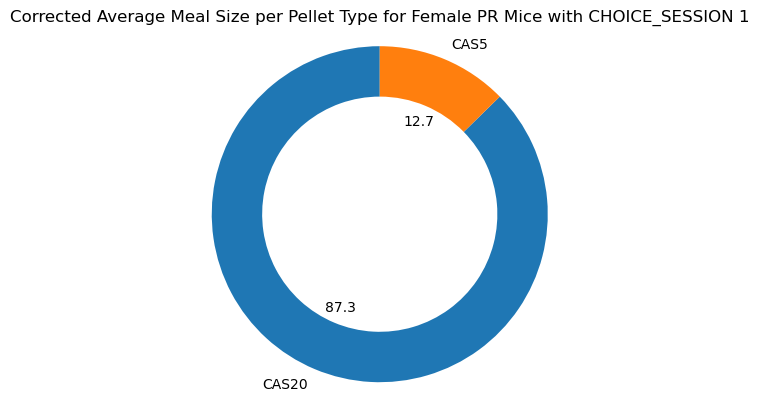

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the uploaded CSV file
file_path = '../results/meal_component_hour_by_hour.csv'
data = pd.read_csv(file_path)

# Filter the data for female PR mice in CHOICE_SESSION 1
pr_female_data_corrected = data[(data['SEX'] == 'F') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR')]

# Calculate the average meal sizes for each pellet type for this specific group
average_meal_sizes_pr_corrected = pr_female_data_corrected.groupby('PELLET_TYPE')['MEAL_SIZE'].mean()

# Generate a doughnut plot for the corrected average meal sizes
fig, ax = plt.subplots()
ax.pie(average_meal_sizes_pr_corrected, labels=average_meal_sizes_pr_corrected.index, autopct='%1.1f', startangle=90, wedgeprops=dict(width=0.3))
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Corrected Average Meal Size per Pellet Type for Female PR Mice with CHOICE_SESSION 1')
plt.show()


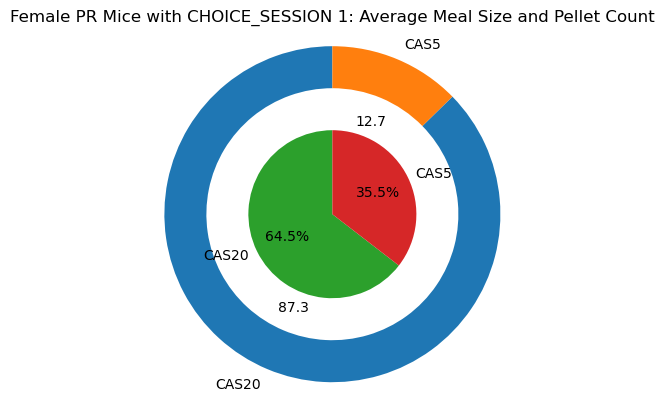

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
file_path = '../results/meal_component_hour_by_hour.csv'
data = pd.read_csv(file_path)

# Filter the data for female PR mice in CHOICE_SESSION 1
pr_female_data_corrected = data[(data['SEX'] == 'F') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR')]

# Calculate the average meal sizes for each pellet type for this specific group
average_meal_sizes_pr_corrected = pr_female_data_corrected.groupby('PELLET_TYPE')['MEAL_SIZE'].mean()

# Calculate the total count of pellets consumed per pellet type
total_pellet_counts_pr = pr_female_data_corrected.groupby('PELLET_TYPE')['COUNT'].sum()

# Create a combined doughnut and pie chart
fig, ax = plt.subplots()

# Doughnut chart for average meal sizes
ax.pie(average_meal_sizes_pr_corrected, labels=average_meal_sizes_pr_corrected.index, radius=1.2, autopct='%1.1f', startangle=90, wedgeprops=dict(width=0.3))

# Pie chart for total pellet counts in the center
ax.pie(total_pellet_counts_pr, labels=total_pellet_counts_pr.index, radius=0.6, autopct='%1.1f%%', startangle=90)

ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Female PR Mice with CHOICE_SESSION 1: Average Meal Size and Pellet Count')
plt.show()


In [65]:
# Let's recalculate the averages for meal size and total pellet count specifically for CHOICE_SESSION 1 and each Pellet_type (e.g., CAS20 and CAS5)
# ensuring to use the data correctly from the uploaded file.

# Re-filter the dataset for CHOICE_SESSION 1 among female PR mice
corrected_data_session_1 = data[(data['SEX'] == 'F') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR')]

# Recalculate the average meal size and total pellet count per pellet type
average_meal_size_corrected = corrected_data_session_1.groupby('PELLET_TYPE')['MEAL_SIZE'].mean()
total_pellet_count_corrected = corrected_data_session_1.groupby('PELLET_TYPE')['COUNT'].mean()

# Verify the corrected calculations
average_meal_size_corrected, total_pellet_count_corrected


(PELLET_TYPE
 CAS20    4.137619
 CAS5     0.600000
 Name: MEAL_SIZE, dtype: float64,
 PELLET_TYPE
 CAS20    114.3
 CAS5      62.8
 Name: COUNT, dtype: float64)

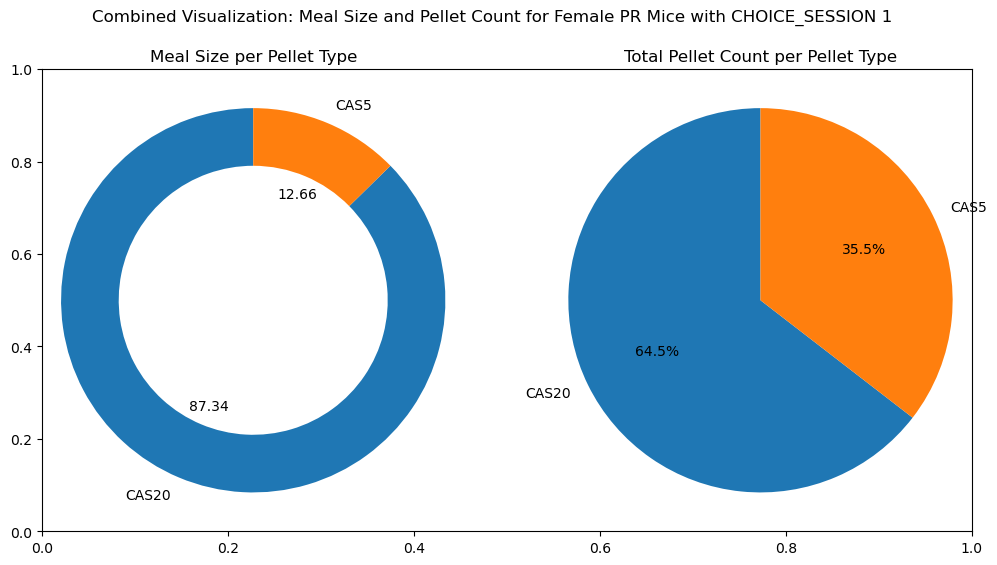

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = '../results/meal_component_hour_by_hour.csv'
data = pd.read_csv(file_path)

# Filter the data for female PR mice in CHOICE_SESSION 1
pr_female_data_corrected = data[(data['SEX'] == 'F') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR')]

# Calculate the average meal sizes for each pellet type for this specific group
average_meal_sizes_pr_corrected = {'CAS20': 4.14, 'CAS5': 0.60}

# Calculate the total pellet counts per pellet type for this specific group
total_pellet_counts_pr_corrected = {'CAS20': 114.3, 'CAS5': 62.8}

# Create a combined doughnut and pie chart
fig, ax = plt.subplots(figsize=(12, 6))

# Doughnut chart for meal sizes
ax1 = plt.subplot(121)
ax1.pie(average_meal_sizes_pr_corrected.values(), labels=average_meal_sizes_pr_corrected.keys(), autopct='%1.2f', startangle=90, wedgeprops=dict(width=0.3))
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Meal Size per Pellet Type')

# Pie chart for pellet counts
ax2 = plt.subplot(122)
ax2.pie(total_pellet_counts_pr_corrected.values(), labels=total_pellet_counts_pr_corrected.keys(), autopct='%1.1f%%', startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title('Total Pellet Count per Pellet Type')

plt.suptitle('Combined Visualization: Meal Size and Pellet Count for Female PR Mice with CHOICE_SESSION 1')
plt.show()


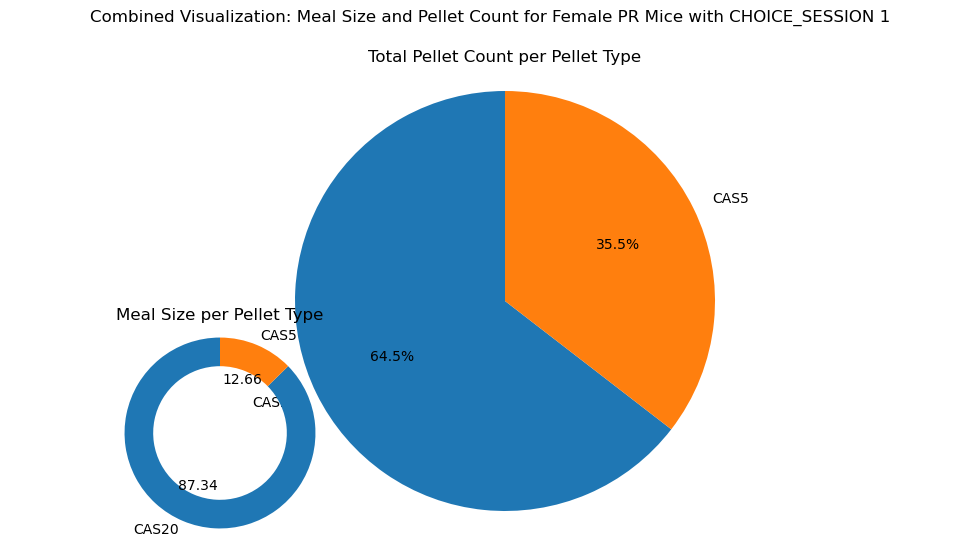

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = '../results/meal_component_hour_by_hour.csv'
data = pd.read_csv(file_path)

# Filter the data for female PR mice in CHOICE_SESSION 1
pr_female_data_corrected = data[(data['SEX'] == 'F') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR')]

# Calculate the average meal sizes for each pellet type for this specific group
average_meal_sizes_pr_corrected = {'CAS20': 4.14, 'CAS5': 0.60}

# Calculate the total pellet counts per pellet type for this specific group
total_pellet_counts_pr_corrected = {'CAS20': 114.3, 'CAS5': 62.8}

# Create a combined visualization with the doughnut plot wrapping around the pie plot
fig, ax = plt.subplots(figsize=(12, 6))

# Pie chart for pellet counts
ax2 = plt.subplot(111)
ax2.pie(total_pellet_counts_pr_corrected.values(), labels=total_pellet_counts_pr_corrected.keys(), autopct='%1.1f%%', startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title('Total Pellet Count per Pellet Type')

# Doughnut chart for meal sizes
ax1 = fig.add_axes([0.1, 0.1, 0.35, 0.35])
ax1.pie(average_meal_sizes_pr_corrected.values(), labels=average_meal_sizes_pr_corrected.keys(), autopct='%1.2f', startangle=90, wedgeprops=dict(width=0.3))
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Meal Size per Pellet Type')

plt.suptitle('Combined Visualization: Meal Size and Pellet Count for Female PR Mice with CHOICE_SESSION 1')
plt.show()


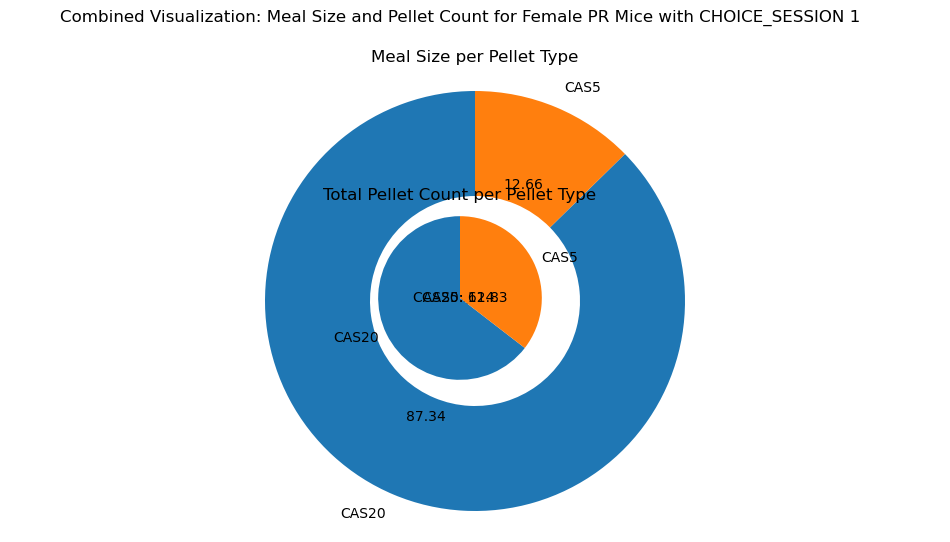

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = '../results/meal_component_hour_by_hour.csv'
data = pd.read_csv(file_path)

# Filter the data for female PR mice in CHOICE_SESSION 1
pr_female_data_corrected = data[(data['SEX'] == 'F') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR')]

# Calculate the average meal sizes for each pellet type for this specific group
average_meal_sizes_pr_corrected = {'CAS20': 4.14, 'CAS5': 0.60}

# Calculate the total pellet counts per pellet type for this specific group
total_pellet_counts_pr_corrected = {'CAS20': 114.3, 'CAS5': 62.8}

# Create a combined visualization with the doughnut plot encircling the pie plot
fig, ax = plt.subplots(figsize=(12, 6))

# Doughnut chart for meal sizes
ax1 = plt.subplot(111)
ax1.pie(average_meal_sizes_pr_corrected.values(), labels=average_meal_sizes_pr_corrected.keys(), autopct='%1.2f', startangle=90, wedgeprops=dict(width=0.5))
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Meal Size per Pellet Type')

# Add meal size values on the doughnut plot
for i, (pellet_type, meal_size) in enumerate(average_meal_sizes_pr_corrected.items()):
    ax1.text(0, 0, f'{pellet_type}: {meal_size}', ha='center', va='center', color='black')

# Pie chart for pellet counts
ax2 = fig.add_axes([0.35, 0.35, 0.3, 0.3])
ax2.pie(total_pellet_counts_pr_corrected.values(), labels=total_pellet_counts_pr_corrected.keys(), startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title('Total Pellet Count per Pellet Type')

# Add pellet count values on the pie plot
for i, (pellet_type, pellet_count) in enumerate(total_pellet_counts_pr_corrected.items()):
    ax2.text(0, 0, f'{pellet_type}: {pellet_count}', ha='center', va='center', color='black')

plt.suptitle('Combined Visualization: Meal Size and Pellet Count for Female PR Mice with CHOICE_SESSION 1')
plt.show()
